In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import timedelta

In [5]:
def get_market_cap():
    crsp = pd.concat([pd.read_csv('exam_period_v6.csv'), pd.read_csv('test_period_top25_11Jun24_1546.csv')], ignore_index=False)

    crsp = crsp.drop_duplicates(subset=['PERMCO', 'date'])
    crsp['market_cap'] = (crsp['PRC'].abs() / crsp['CFACPR']) * (crsp['SHROUT'] * crsp['CFACSHR'])

    crsp['date'] = pd.to_datetime(crsp['date'])
    crsp['fri_of_week'] = crsp['date'].dt.to_period('W-FRI').apply(lambda r: r.end_time).dt.date

    mkt_cap = crsp.groupby(['PERMCO', 'fri_of_week'])['market_cap'].mean().reset_index()

    ## next_fri_of_week is the week for the target
    mkt_cap['next_fri_of_week'] = mkt_cap['fri_of_week'] + timedelta(days=7)
    mkt_cap['next_fri_of_week'] = mkt_cap['next_fri_of_week'].astype(str)

    return mkt_cap

In [6]:
df_market_cap = get_market_cap()

<ipython-input-5-e87a11ad2851>:2: DtypeWarning: Columns (9,22,24,49,57) have mixed types. Specify dtype option on import or set low_memory=False.
  crsp = pd.concat([pd.read_csv('exam_period_v6.csv'), pd.read_csv('test_period_top25_11Jun24_1546.csv')], ignore_index=False)
<ipython-input-5-e87a11ad2851>:2: DtypeWarning: Columns (9,22,24,49,57) have mixed types. Specify dtype option on import or set low_memory=False.
  crsp = pd.concat([pd.read_csv('exam_period_v6.csv'), pd.read_csv('test_period_top25_11Jun24_1546.csv')], ignore_index=False)


In [7]:
def get_mkt_port(strategy):
    sp500_port = pd.read_csv('./crsp_sp500_2016-2023.csv')
    sp500_port.sort_values(by=['caldt'])
    ## Calculate weekly return
    sp500_port['caldt'] = pd.to_datetime(sp500_port['caldt'])
    sp500_port['fri_of_week'] = sp500_port['caldt'].dt.to_period('W-FRI').apply(lambda r: r.end_time).dt.date

    sp500_port = sp500_port.groupby('fri_of_week').agg({
        'ewretd': (lambda x: (np.exp(np.sum(np.log(1 + x))) - 1)),
        'vwretd': (lambda x: (np.exp(np.sum(np.log(1 + x))) - 1))
    }).reset_index()
    sp500_port.columns = ['To', 'ewretd', 'vwretd']

    sp500_port['model'] = 'Market'

    ## Get return for each model and year
    groupby_cols = ['model', 'To']

    if strategy == 'EW':
        sp500_port['log_return'] = np.log(1 + sp500_port['ewretd'])
    elif strategy == 'VW':
        sp500_port['log_return'] = np.log(1 + sp500_port['vwretd'])
    else:
        print('you input wrong nonexisting strategy')
        return

    ## Calculate cumulative log return
    sp500_port = sp500_port.sort_values(by=['model', 'To'])
    sp500_port['cummu_log_return'] = (sp500_port['log_return']).cumsum()

    return sp500_port

In [8]:
ew_mkt_port = get_mkt_port('EW')
vw_mkt_port = get_mkt_port('VW')

In [9]:
bert_score = pd.read_csv('./scores/scores_bert.csv')
roberta_score = pd.read_csv('./scores/scores_roberta.csv')
dBert_score = pd.read_csv('./scores/scores_distilbert.csv')
dRoBerta_score = pd.read_csv('./scores/scores_distilroberta.csv')
finbert_score = pd.read_csv('./scores/scores_finbert.csv')


bert_score['model'] = 'BERT'
roberta_score['model'] = 'RoBERTa'
dBert_score['model'] = 'DistilBERT'
dRoBerta_score['model'] = 'DistilRoBERTa'
finbert_score['model'] = 'FinBERT'

In [10]:
def cal_log_return(df_of_aModel_merged):
    ## Scaling down the returns by a constant factor
    scaling_factore = 0.01
    df_of_aModel_merged['inv_return'] = df_of_aModel_merged['inv_return'] * scaling_factore

    ## Get return for each model
    groupby_cols = ['model', 'Week', 'From', 'To']
    df_of_aModel_merged = df_of_aModel_merged.groupby(groupby_cols)[['inv_return']].mean().reset_index()
    df_of_aModel_merged['log_return'] = np.log(1 + df_of_aModel_merged['inv_return'])

    ## Calculate cumulative log L-return
    df_of_aModel_merged = df_of_aModel_merged.sort_values(by=['model', 'From'])
    df_of_aModel_merged['cummu_log_return'] = (df_of_aModel_merged['log_return']).cumsum()

    ## Change column type
    df_of_aModel_merged['To'] = pd.to_datetime(df_of_aModel_merged['To'])

    return df_of_aModel_merged

In [11]:
def EW_L_portfolio(df_of_aModel):
    qScore_of_aModel = df_of_aModel.groupby(['model','From', 'To'])['sentiment_score']\
    .agg([lambda x: x.quantile(0.9)])\
    .reset_index()
    qScore_of_aModel.columns = ['model', 'From', 'To', 'P90']

    df_of_aModel_merged = pd.merge(df_of_aModel, qScore_of_aModel, how='left', on=['model', 'From', 'To'])
    df_of_aModel_merged['is_long_position'] = np.where(df_of_aModel_merged['sentiment_score'] >= df_of_aModel_merged['P90'], 1, 0)

    df_of_aModel_merged = df_of_aModel_merged[df_of_aModel_merged['is_long_position'] == 1]
    df_of_aModel_merged['inv_return'] = df_of_aModel_merged['is_long_position'] * df_of_aModel_merged['Return']

    df_of_aModel_merged = cal_log_return(df_of_aModel_merged)

    return df_of_aModel_merged

In [12]:
def EW_S_portfolio(df_of_aModel):
    qScore_of_aModel = df_of_aModel.groupby(['model','From', 'To'])['sentiment_score']\
    .agg([lambda x: x.quantile(0.1)])\
    .reset_index()
    qScore_of_aModel.columns = ['model', 'From', 'To', 'P10']

    df_of_aModel_merged = pd.merge(df_of_aModel, qScore_of_aModel, how='left', on=['model', 'From', 'To'])
    df_of_aModel_merged['is_short_position'] = np.where(df_of_aModel_merged['sentiment_score'] <= df_of_aModel_merged['P10'], 1, 0)

    df_of_aModel_merged = df_of_aModel_merged[df_of_aModel_merged['is_short_position'] == 1]
    df_of_aModel_merged['inv_return'] = -1 * df_of_aModel_merged['is_short_position'] * df_of_aModel_merged['Return']

    df_of_aModel_merged = cal_log_return(df_of_aModel_merged)

    return df_of_aModel_merged

In [13]:
def EW_LS_portfolio(df_of_aModel):
    qScore_of_aModel = df_of_aModel.groupby(['model','From', 'To'])['sentiment_score']\
    .agg([lambda x: x.quantile(0.9), lambda x: x.quantile(0.1)])\
    .reset_index()
    qScore_of_aModel.columns = ['model', 'From', 'To', 'P90', 'P10']

    df_of_aModel_merged = pd.merge(df_of_aModel, qScore_of_aModel, how='left', on=['model', 'From', 'To'])
    df_of_aModel_merged['is_long_position'] = np.where(df_of_aModel_merged['sentiment_score'] >= df_of_aModel_merged['P90'], 1, 0)
    df_of_aModel_merged['is_short_position'] = np.where(df_of_aModel_merged['sentiment_score'] <= df_of_aModel_merged['P10'], 1, 0)


    df_of_aModel_merged = df_of_aModel_merged[(df_of_aModel_merged['is_long_position'] == 1) | (df_of_aModel_merged['is_short_position'] == 1)]
    df_of_aModel_merged['long_return'] = df_of_aModel_merged['is_long_position'] * df_of_aModel_merged['Return']
    df_of_aModel_merged['short_return'] = df_of_aModel_merged['is_short_position'] * df_of_aModel_merged['Return']


    ## Scaling down the returns by a constant factor
    scaling_factore = 0.01
    df_of_aModel_merged['long_return'] = df_of_aModel_merged['long_return'] * scaling_factore
    df_of_aModel_merged['short_return'] = df_of_aModel_merged['short_return'] * scaling_factore

    ## Get return for each model
    groupby_cols = ['model', 'Week', 'From', 'To']
    df_of_aModel_merged['inv_return'] = df_of_aModel_merged['long_return'] - df_of_aModel_merged['short_return']
    df_of_aModel_merged = df_of_aModel_merged.groupby(groupby_cols)[['inv_return']].mean().reset_index()
    df_of_aModel_merged['log_return'] = np.log(1 + df_of_aModel_merged['inv_return'])

    ## Calculate cumulative log return
    df_of_aModel_merged = df_of_aModel_merged.sort_values(by=['model', 'From'])
    df_of_aModel_merged['cummu_log_return'] = (df_of_aModel_merged['log_return']).cumsum()

    ## Change column type
    df_of_aModel_merged['To'] = pd.to_datetime(df_of_aModel_merged['To'])

    return df_of_aModel_merged

In [14]:
def VW_L_portfolio(df_of_aModel):
    qScore_of_aModel = df_of_aModel.groupby(['model','From', 'To'])['sentiment_score']\
    .agg([lambda x: x.quantile(0.9)])\
    .reset_index()
    qScore_of_aModel.columns = ['model', 'From', 'To', 'P90']

    df_of_aModel_merged = pd.merge(df_of_aModel, qScore_of_aModel, how='left', on=['model', 'From', 'To'])
    df_of_aModel_merged['is_long_position'] = np.where(df_of_aModel_merged['sentiment_score'] >= df_of_aModel_merged['P90'], 1, 0)

    df_of_aModel_merged = df_of_aModel_merged[df_of_aModel_merged['is_long_position'] == 1]

    ## Get weights
    df_of_aModel_merged = pd.merge(df_of_aModel_merged, df_market_cap,
                                   left_on=['PERMCO', 'To'],
                                   right_on=['PERMCO', 'next_fri_of_week'], how='left')
    groupby_cols = ['model', 'Week', 'From', 'To']
    total_market_cap = df_of_aModel_merged.groupby(groupby_cols)['market_cap'].sum().reset_index()
    total_market_cap = total_market_cap.rename(columns={'market_cap': 'market_cap_total'})

    df_of_aModel_merged = pd.merge(df_of_aModel_merged, total_market_cap, on=groupby_cols, how='left')
    df_of_aModel_merged['weight'] = df_of_aModel_merged['market_cap'] / df_of_aModel_merged['market_cap_total']

    df_of_aModel_merged['inv_return'] = df_of_aModel_merged['is_long_position'] \
                                            * df_of_aModel_merged['Return']\
                                            * df_of_aModel_merged['weight']

    df_of_aModel_merged = cal_log_return(df_of_aModel_merged)

    return df_of_aModel_merged

In [15]:
def VW_S_portfolio(df_of_aModel):
    qScore_of_aModel = df_of_aModel.groupby(['model','From', 'To'])['sentiment_score']\
    .agg([lambda x: x.quantile(0.1)])\
    .reset_index()
    qScore_of_aModel.columns = ['model', 'From', 'To', 'P10']

    df_of_aModel_merged = pd.merge(df_of_aModel, qScore_of_aModel, how='left', on=['model', 'From', 'To'])
    df_of_aModel_merged['is_short_position'] = np.where(df_of_aModel_merged['sentiment_score'] <= df_of_aModel_merged['P10'], 1, 0)

    df_of_aModel_merged = df_of_aModel_merged[df_of_aModel_merged['is_short_position'] == 1]

    ## Get weights
    df_of_aModel_merged = pd.merge(df_of_aModel_merged, df_market_cap,
                                   left_on=['PERMCO', 'To'],
                                   right_on=['PERMCO', 'next_fri_of_week'], how='left')
    groupby_cols = ['model', 'Week', 'From', 'To']
    total_market_cap = df_of_aModel_merged.groupby(groupby_cols)['market_cap'].sum().reset_index()
    total_market_cap = total_market_cap.rename(columns={'market_cap': 'market_cap_total'})

    df_of_aModel_merged = pd.merge(df_of_aModel_merged, total_market_cap, on=groupby_cols, how='left')
    df_of_aModel_merged['weight'] = df_of_aModel_merged['market_cap'] / df_of_aModel_merged['market_cap_total']

    df_of_aModel_merged['inv_return'] = -1 * df_of_aModel_merged['is_short_position'] \
                                            * df_of_aModel_merged['Return']\
                                            * df_of_aModel_merged['weight']

    df_of_aModel_merged = cal_log_return(df_of_aModel_merged)

    return df_of_aModel_merged

In [16]:
def VW_LS_portfoilio(df_of_aModel):
    qScore_of_aModel = df_of_aModel.groupby(['model','From', 'To'])['sentiment_score']\
    .agg([lambda x: x.quantile(0.9), lambda x: x.quantile(0.1)])\
    .reset_index()
    qScore_of_aModel.columns = ['model', 'From', 'To', 'P90', 'P10']

    df_of_aModel_merged = pd.merge(df_of_aModel, qScore_of_aModel, how='left', on=['model', 'From', 'To'])
    df_of_aModel_merged['is_long_position'] = np.where(df_of_aModel_merged['sentiment_score'] >= df_of_aModel_merged['P90'], 1, 0)
    df_of_aModel_merged['is_short_position'] = np.where(df_of_aModel_merged['sentiment_score'] <= df_of_aModel_merged['P10'], 1, 0)


    df_of_aModel_merged = df_of_aModel_merged[(df_of_aModel_merged['is_long_position'] == 1) | (df_of_aModel_merged['is_short_position'] == 1)]
    df_of_aModel_merged['long_return'] = df_of_aModel_merged['is_long_position'] * df_of_aModel_merged['Return']
    df_of_aModel_merged['short_return'] = df_of_aModel_merged['is_short_position'] * df_of_aModel_merged['Return']


    ## Scaling down the returns by a constant factor
    scaling_factore = 0.01
    df_of_aModel_merged['long_return'] = df_of_aModel_merged['long_return'] * scaling_factore
    df_of_aModel_merged['short_return'] = df_of_aModel_merged['short_return'] * scaling_factore


    ## Get weights
    df_of_aModel_merged = pd.merge(df_of_aModel_merged, df_market_cap,
                                   left_on=['PERMCO', 'To'],
                                   right_on=['PERMCO', 'next_fri_of_week'], how='left')
    groupby_cols = ['model', 'Week', 'From', 'To']
    total_market_cap = df_of_aModel_merged.groupby(groupby_cols)['market_cap'].sum().reset_index()
    total_market_cap = total_market_cap.rename(columns={'market_cap': 'market_cap_total'})

    df_of_aModel_merged = pd.merge(df_of_aModel_merged, total_market_cap, on=groupby_cols, how='left')
    df_of_aModel_merged['weight'] = df_of_aModel_merged['market_cap'] / df_of_aModel_merged['market_cap_total']


    ## Get return for each model
    groupby_cols = ['model', 'Week', 'From', 'To']
    df_of_aModel_merged['inv_return'] = df_of_aModel_merged['long_return']\
                                            * df_of_aModel_merged['weight']\
                                        - df_of_aModel_merged['short_return']\
                                            * df_of_aModel_merged['weight']
    df_of_aModel_merged = df_of_aModel_merged.groupby(groupby_cols)[['inv_return']].mean().reset_index()
    df_of_aModel_merged['log_return'] = np.log(1 + df_of_aModel_merged['inv_return'])

    ## Calculate cumulative log L-return
    df_of_aModel_merged = df_of_aModel_merged.sort_values(by=['model', 'From'])
    df_of_aModel_merged['cummu_log_return'] = (df_of_aModel_merged['log_return']).cumsum()

    ## Change column type
    df_of_aModel_merged['To'] = pd.to_datetime(df_of_aModel_merged['To'])

    return df_of_aModel_merged

In [17]:
def plot_by_model(df_score, model_name):

    # Plotting
    plt.figure(figsize=(12, 6))

    ew_l_p = EW_L_portfolio(df_score)
    plt.plot(ew_l_p['To'], ew_l_p['cummu_log_return'], label='EW L')

    ew_s_p = EW_S_portfolio(df_score)
    plt.plot(ew_s_p['To'], ew_s_p['cummu_log_return'], label='EW S')

    ew_ls_p = EW_LS_portfolio(df_score)
    plt.plot(ew_ls_p['To'], ew_ls_p['cummu_log_return'], label='EW LS')

    vw_l_p = VW_L_portfolio(df_score)
    plt.plot(vw_l_p['To'], vw_l_p['cummu_log_return'], label='VW L')

    vw_s_p = VW_S_portfolio(df_score)
    plt.plot(vw_s_p['To'], vw_s_p['cummu_log_return'], label='VW S')

    vw_ls_p = VW_LS_portfoilio(df_score)
    plt.plot(vw_ls_p['To'], vw_ls_p['cummu_log_return'], label='VW LS')

    plt.plot(ew_mkt_port['To'], ew_mkt_port['cummu_log_return'], label='Market EW')
    plt.plot(vw_mkt_port['To'], vw_mkt_port['cummu_log_return'], label='Market VW')

    plt.title(f'Performance of US Energy Stocks by {model_name}')
    plt.xlabel('Year')
    plt.ylabel('Cumulative Log Return')

    plt.legend(loc='upper left')  # Specify handles and labels explicitly
    plt.grid(True)

    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format to show only year

    plt.tight_layout()
    plt.show()

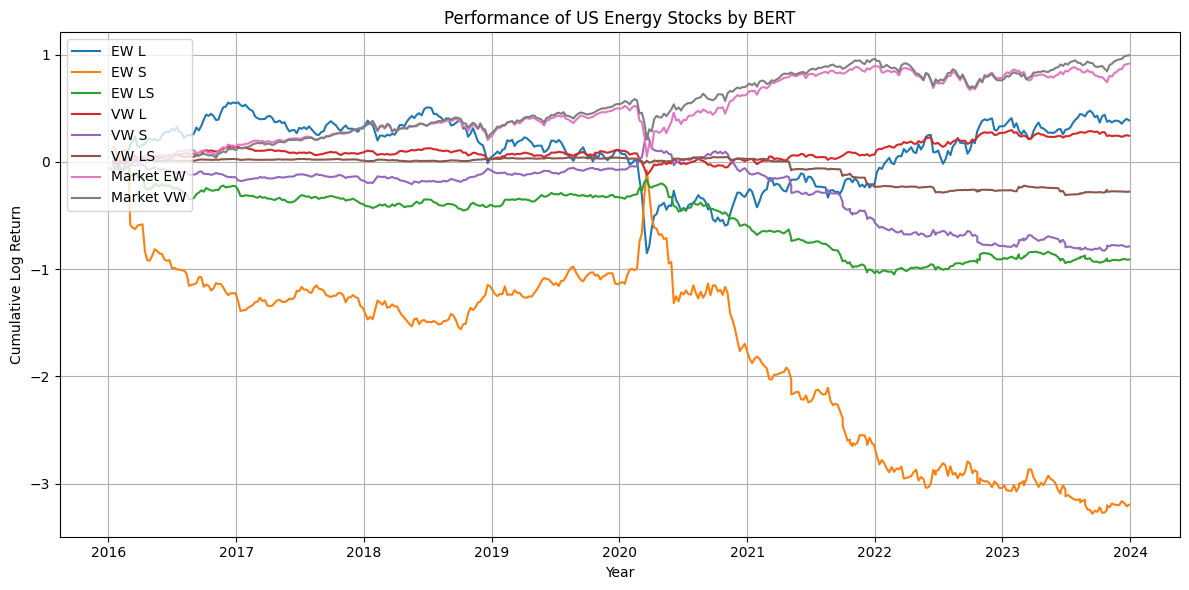

In [18]:
plot_by_model(bert_score, 'BERT')

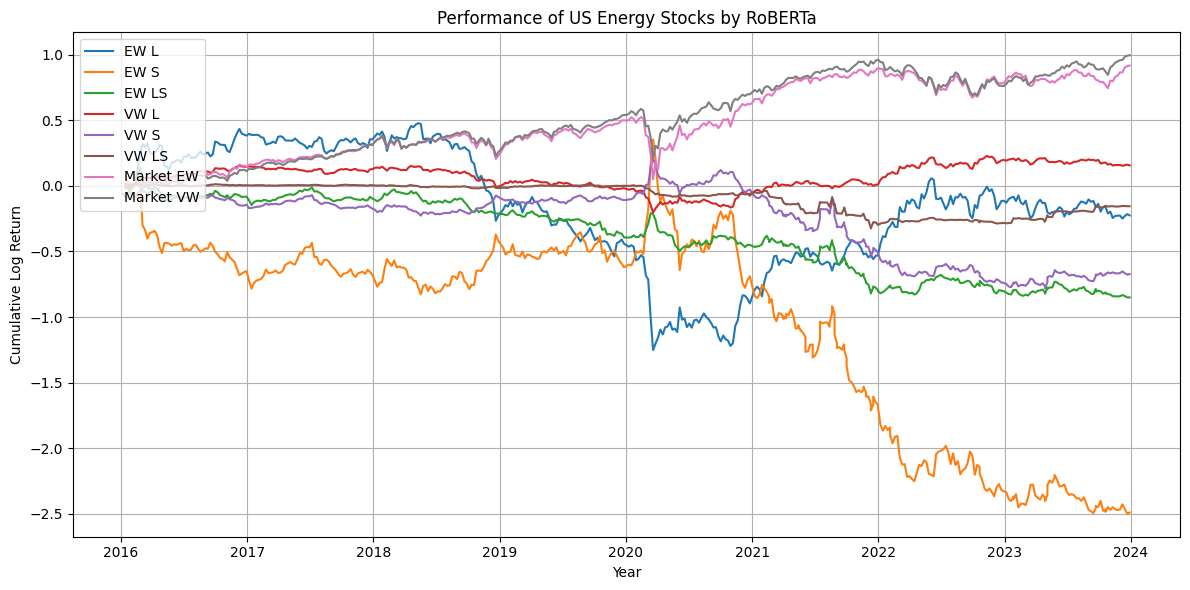

In [19]:
plot_by_model(roberta_score, 'RoBERTa')

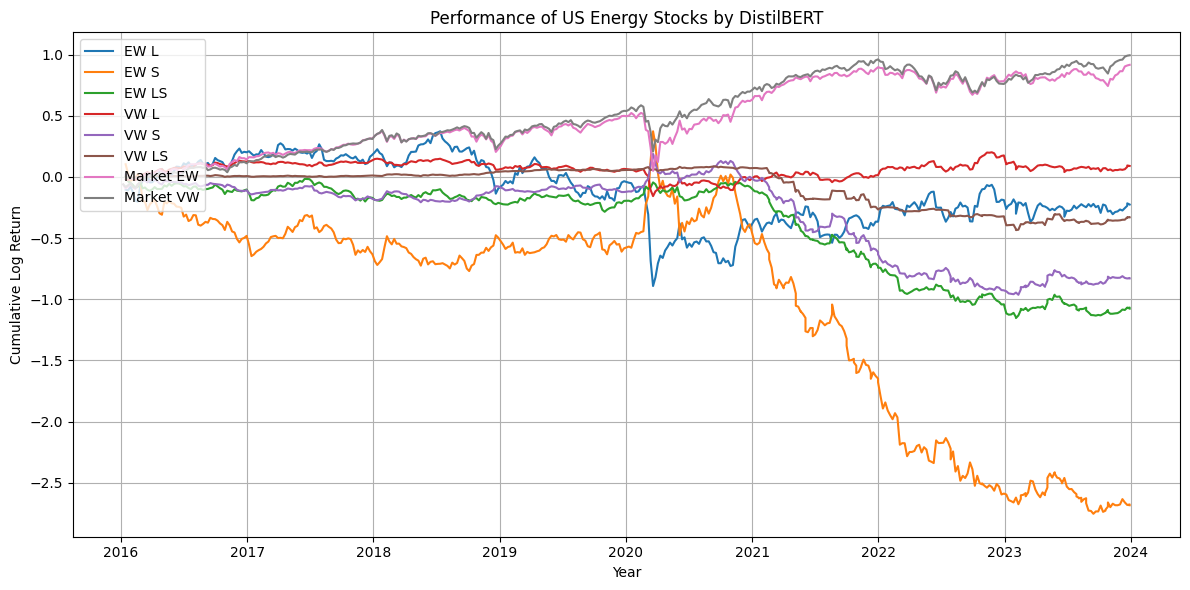

In [20]:
plot_by_model(dBert_score, 'DistilBERT')

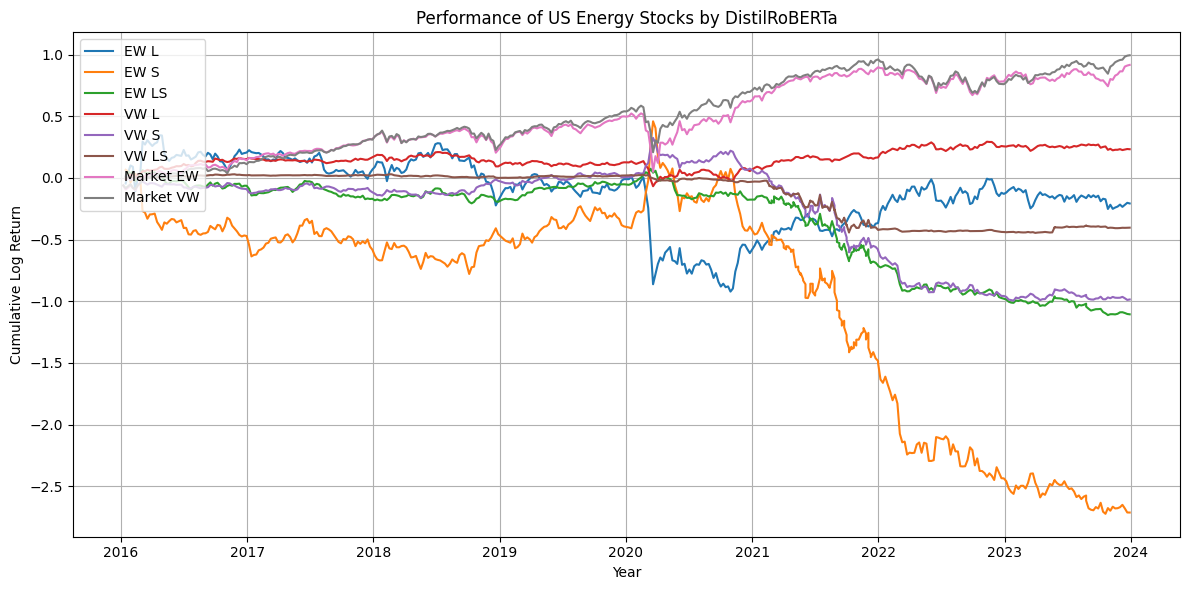

In [21]:
plot_by_model(dRoBerta_score, 'DistilRoBERTa')

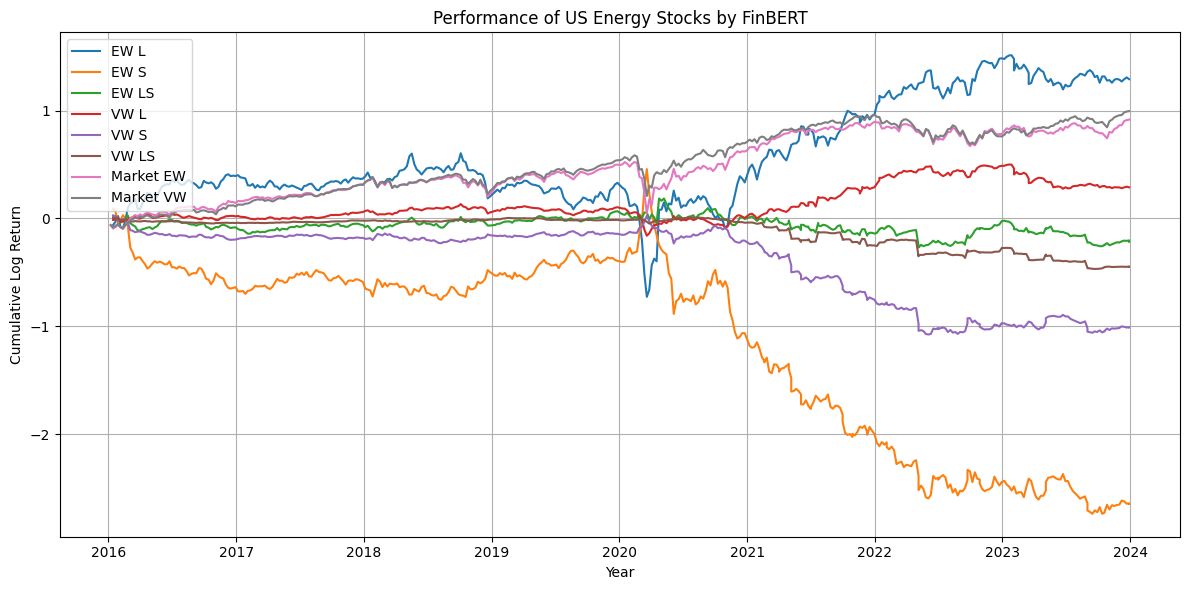

In [22]:
plot_by_model(finbert_score, 'FinBERT')

In [23]:
def plot_by_strategy(strategy):

    if strategy == 'EW L':
        selected_func = EW_L_portfolio
    elif strategy == 'EW S':
        selected_func = EW_S_portfolio
    elif strategy == 'EW LS':
        selected_func = EW_LS_portfolio
    elif strategy == 'VW L':
        selected_func = VW_L_portfolio
    elif strategy == 'VW S':
        selected_func = VW_S_portfolio
    elif strategy == 'VW LS':
        selected_func = VW_LS_portfoilio
    else:
        print('wrong strategy specfied!')
        return

    # Plotting
    plt.figure(figsize=(12, 6))

    bert_p = selected_func(bert_score)
    plt.plot(bert_p['To'], bert_p['cummu_log_return'], label='BERT')

    roberta_p = selected_func(roberta_score)
    plt.plot(roberta_p['To'], roberta_p['cummu_log_return'], label='RoBERTa')

    dBert_p = selected_func(dBert_score)
    plt.plot(dBert_p['To'], dBert_p['cummu_log_return'], label='DistilBERT')

    dRoBerta_p = selected_func(dRoBerta_score)
    plt.plot(dRoBerta_p['To'], dRoBerta_p['cummu_log_return'], label='DistilRoBERTa')

    finbert_p = selected_func(finbert_score)
    plt.plot(finbert_p['To'], finbert_p['cummu_log_return'], label='FinBERT')

    if 'EW' in strategy:
        plt.plot(ew_mkt_port['To'], ew_mkt_port['cummu_log_return'], label='Market')
    elif 'VW' in strategy:
        plt.plot(vw_mkt_port['To'], vw_mkt_port['cummu_log_return'], label='Market')

    plt.title(f'Performance of US Energy Stocks - {strategy}')
    plt.xlabel('Year')
    plt.ylabel('Cumulative Log Return')

    plt.legend(loc='upper left')  # Specify handles and labels explicitly
    plt.grid(True)

    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format to show only year

    plt.tight_layout()
    plt.show()

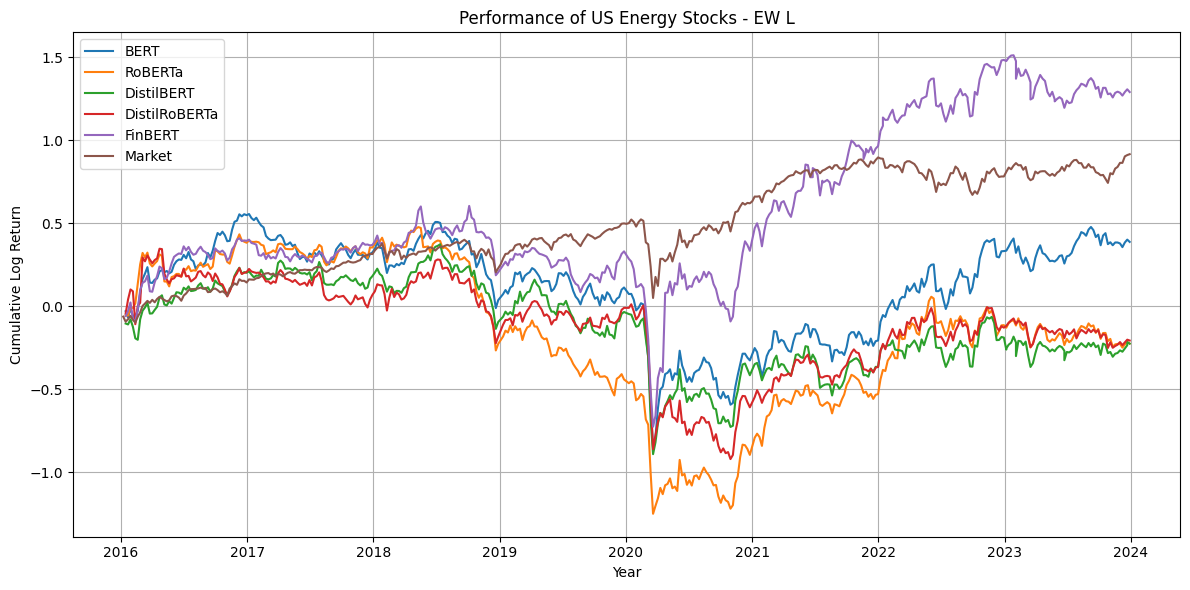

In [24]:
plot_by_strategy('EW L')

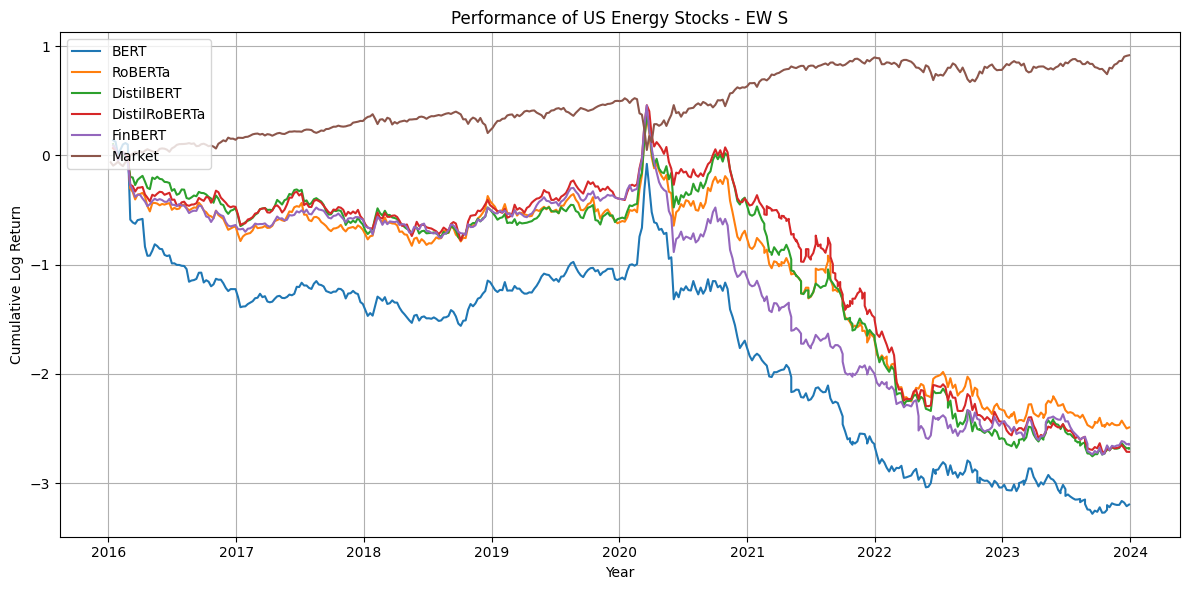

In [25]:
plot_by_strategy('EW S')

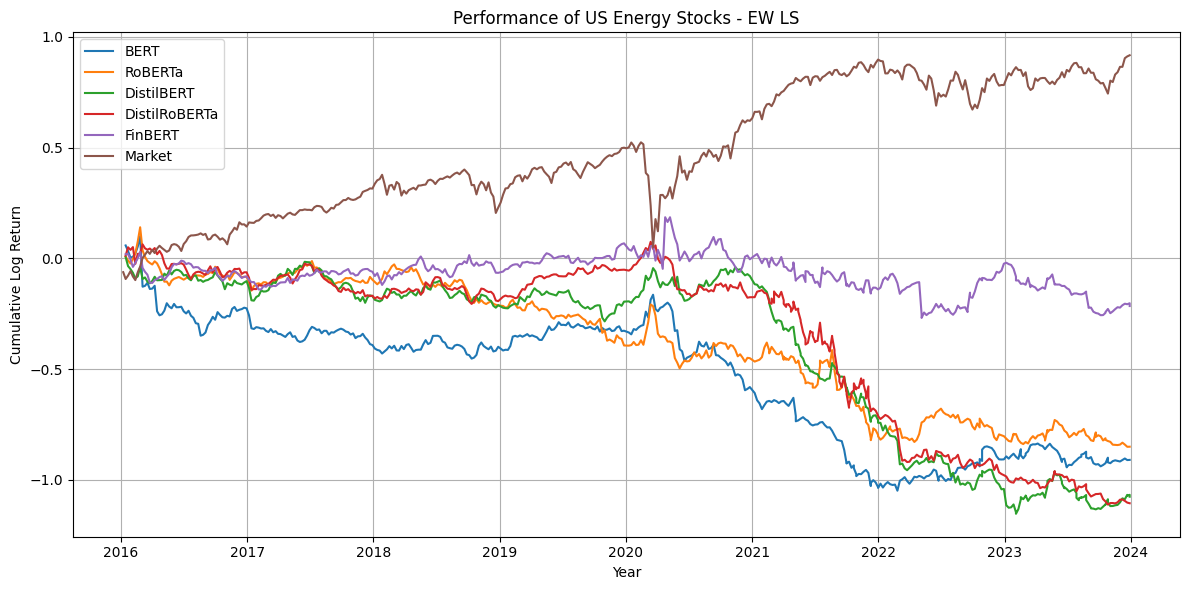

In [26]:
plot_by_strategy('EW LS')

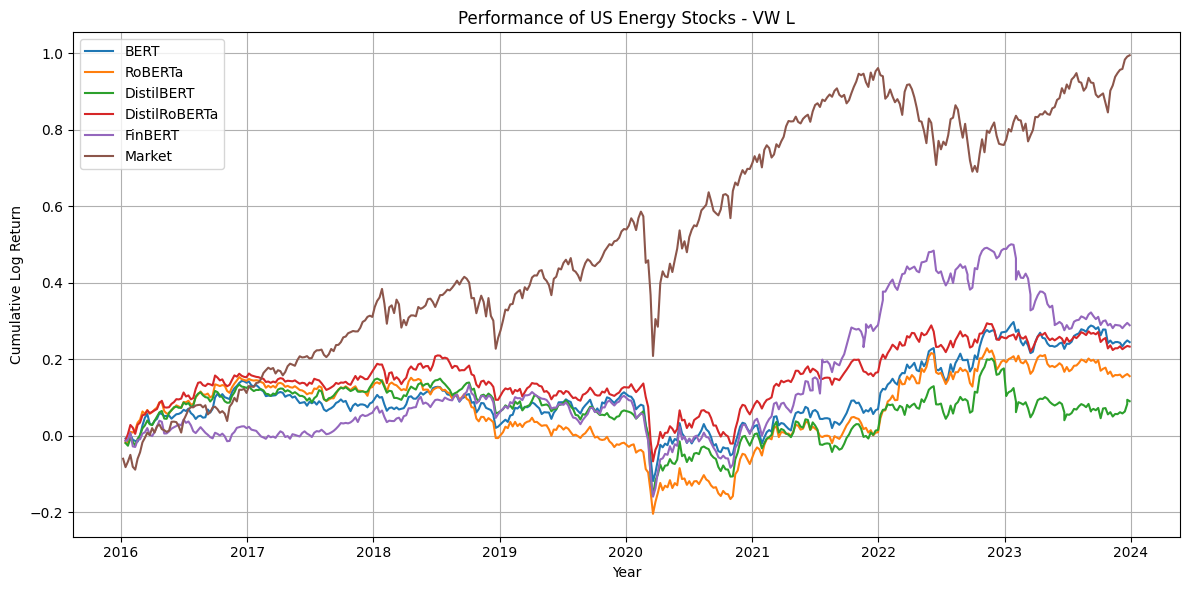

In [27]:
plot_by_strategy('VW L')

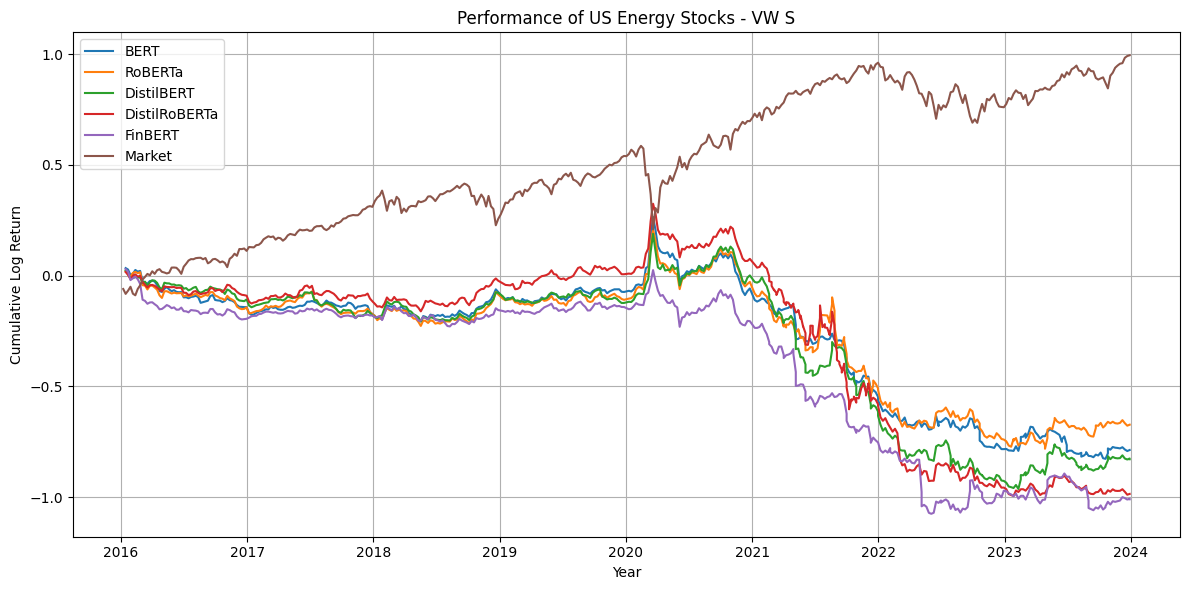

In [28]:
plot_by_strategy('VW S')

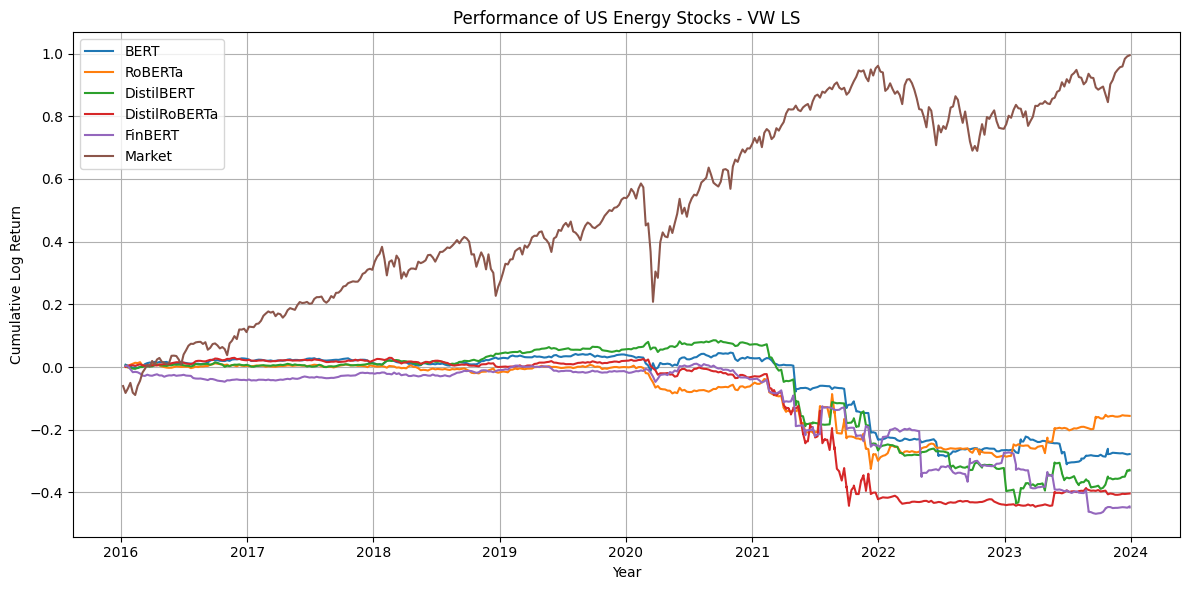

In [29]:
plot_by_strategy('VW LS')

In [36]:
def get_SR(port_df):
    mean = (port_df['log_return']).mean()
    std = (port_df['log_return']).std()
    sr = mean / std * np.sqrt(52)
    return mean, std, sr


def get_SR_report():

    report = []

    for df_score, model_name in [(bert_score, 'BERT'), (roberta_score, 'RoBERTa'),
                                 (dBert_score, 'DistilBERT'), (dRoBerta_score, 'DistilRoBERTa'),
                                 (finbert_score, 'FinBERT')]:

      ew_l_p = EW_L_portfolio(df_score)
      ew_s_p = EW_S_portfolio(df_score)
      ew_ls_p = EW_LS_portfolio(df_score)
      vw_l_p = VW_L_portfolio(df_score)
      vw_s_p = VW_S_portfolio(df_score)
      vw_ls_p = VW_LS_portfoilio(df_score)

      for p, strategy in [(ew_l_p, 'EW L'), (ew_s_p, 'EW S'), (ew_ls_p, 'EW LS'), (vw_l_p, 'VW L'), (vw_s_p, 'VW S'), (vw_ls_p, 'VW LS')]:
          mean, std, sr = get_SR(p)

          report.append({
              'model': model_name,
              'strategy': strategy,
              'Return': mean,
              'Std': std,
              'SR': sr
          })

    return report

In [37]:
report = get_SR_report()
report = pd.DataFrame(report)
report.to_csv('report_sr_all_wd.csv', index=False)
report

<ipython-input-13-30f64e3b1b2f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_of_aModel_merged['long_return'] = df_of_aModel_merged['is_long_position'] * df_of_aModel_merged['Return']
<ipython-input-13-30f64e3b1b2f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_of_aModel_merged['short_return'] = df_of_aModel_merged['is_short_position'] * df_of_aModel_merged['Return']
<ipython-input-13-30f64e3b1b2f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


,model,strategy,Return,Std,SR
0,BERT,EW L,0.000939,0.046959,0.144156
1,BERT,EW S,-0.007449,0.066694,-0.805361
2,BERT,EW LS,-0.002122,0.022449,-0.681537
3,BERT,VW L,0.000592,0.013623,0.313217
4,BERT,VW S,-0.001835,0.019082,-0.693604
5,BERT,VW LS,-0.000647,0.008338,-0.559128
6,RoBERTa,EW L,-0.000546,0.046841,-0.084002
7,RoBERTa,EW S,-0.005659,0.058177,-0.701386
8,RoBERTa,EW LS,-0.001933,0.020472,-0.681040
9,RoBERTa,VW L,0.000376,0.013491,0.201236


In [38]:
report_pivoted = report.pivot_table(index=['model', 'strategy'], values=['Return', 'Std', 'SR']).stack().unstack('model').unstack(0)
# report_pivoted.columns = [' '.join(col).strip() for col in report_pivoted.columns.values]
report_pivoted

model         BERT                                                    \
strategy      EW L     EW LS      EW S      VW L     VW LS      VW S   
Return    0.000939 -0.002122 -0.007449  0.000592 -0.000647 -0.001835   
SR        0.144156 -0.681537 -0.805361  0.313217 -0.559128 -0.693604   
Std       0.046959  0.022449  0.066694  0.013623  0.008338  0.019082   

model    DistilBERT                                ...   FinBERT            \
strategy       EW L     EW LS      EW S      VW L  ...      EW S      VW L   
Return    -0.000540 -0.002403 -0.006058  0.000215  ... -0.006112  0.000684   
SR        -0.084396 -0.870724 -0.779770  0.105230  ... -0.813851  0.310432   
Std        0.046125  0.019899  0.056027  0.014736  ...  0.054152  0.015886   

model                          RoBERTa                                \
strategy     VW LS      VW S      EW L     EW LS      EW S      VW L   
Return   -0.001013 -0.002332 -0.000546 -0.001933 -0.005659  0.000376   
SR       -0.555370 -0.869975 -0.084002 -0.681040 -0.701386  0.201236   
Std       0.013149  0.019332  0.046841  0.020472  0.058177  0.013491   

model                         
strategy     VW LS      VW S  
Return   -0.000354 -0.001530  
SR       -0.228624 -0.528975  
Std       0.011162  0.020854  

[3 rows x 30 columns]

In [39]:
report_pivoted = report.pivot_table(index=['model', 'strategy'], values=['Return', 'Std', 'SR']).stack().unstack('model').unstack(0)

# Desired order for models and strategies
model_order = ['BERT', 'RoBERTa', 'DistilBERT', 'DistilRoBERTa', 'FinBERT']
strategy_order = ['EW L', 'EW S', 'EW LS', 'VW L', 'VW S', 'VW LS']  # Adjust this as per actual strategies

# Reordering the DataFrame columns to match the desired order
report_pivoted = report_pivoted.sort_index(axis=1, level='model', key=lambda x: x.map(lambda y: model_order.index(y)))

report_pivoted = report_pivoted.sort_index(axis=1, level='strategy', key=lambda x: x.map(lambda y: strategy_order.index(y)))


report_pivoted = report_pivoted.reset_index()

report_pivoted.to_csv('./report_sr_all_pivoted_wd.csv', index=False)
report_pivoted

model,index,BERT,DistilBERT,DistilRoBERTa,FinBERT,RoBERTa,BERT,DistilBERT,DistilRoBERTa,FinBERT,...,BERT,DistilBERT,DistilRoBERTa,FinBERT,RoBERTa,BERT,DistilBERT,DistilRoBERTa,FinBERT,RoBERTa
strategy,,EW L,EW L,EW L,EW L,EW L,EW S,EW S,EW S,EW S,...,VW S,VW S,VW S,VW S,VW S,VW LS,VW LS,VW LS,VW LS,VW LS
0,Return,0.000939,-0.000540,-0.000501,0.003060,-0.000546,-0.007449,-0.006058,-0.006003,-0.006112,...,-0.001835,-0.001871,-0.002181,-0.002332,-0.001530,-0.000647,-0.000736,-0.000892,-0.001013,-0.000354
1,SR,0.144156,-0.084396,-0.075795,0.407216,-0.084002,-0.805361,-0.779770,-0.815936,-0.813851,...,-0.693604,-0.676379,-0.717829,-0.869975,-0.528975,-0.559128,-0.478632,-0.504360,-0.555370,-0.228624
2,Std,0.046959,0.046125,0.047691,0.054185,0.046841,0.066694,0.056027,0.053053,0.054152,...,0.019082,0.019952,0.021905,0.019332,0.020854,0.008338,0.011083,0.012759,0.013149,0.011162


In [42]:
ew_mkt_port

,To,ewretd,vwretd,model,log_return,cummu_log_return
0,2016-01-08,-0.060859,-0.058702,Market,-0.062789,-0.062789
1,2016-01-15,-0.030372,-0.021772,Market,-0.030843,-0.093632
2,2016-01-22,0.015565,0.014513,Market,0.015445,-0.078187
3,2016-01-29,0.020412,0.017869,Market,0.020206,-0.057981
4,2016-02-05,-0.023899,-0.030748,Market,-0.024189,-0.082170
...,...,...,...,...,...,...
412,2023-12-01,0.024549,0.008296,Market,0.024252,0.864188
413,2023-12-08,0.000073,0.002408,Market,0.000073,0.864261
414,2023-12-15,0.039763,0.024663,Market,0.038993,0.903254
415,2023-12-22,0.008020,0.007968,Market,0.007988,0.911242


In [43]:
get_SR(ew_mkt_port)

(0.0021977671041975054, 0.02801237203931944, 0.5657615838165649)

In [44]:
get_SR(vw_mkt_port)

(0.002385384025434463, 0.024601793662117868, 0.6991867774763103)